# 1. 데이터셋 다운로드

In [1]:
# download dataset by url link
!wget -O dataset.zip https://www.dropbox.com/s/pj6zfdf5f5l6rhe/imitation_22ver.zip?dl=0
# unzip zip file
!unzip -qq dataset.zip
# delete downloaded zip file
!rm -rf dataset.zip
# rename data path
!mv imitation_22ver/ dataset/

--2022-12-14 07:21:10--  https://www.dropbox.com/s/pj6zfdf5f5l6rhe/imitation_22ver.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/pj6zfdf5f5l6rhe/imitation_22ver.zip [following]
--2022-12-14 07:21:10--  https://www.dropbox.com/s/raw/pj6zfdf5f5l6rhe/imitation_22ver.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd386bfc76542e9b84f5ed4fb54.dl.dropboxusercontent.com/cd/0/inline/BymzNvSO5-Meh3TOVjriF4gqB40-as9U9HHMZrExTaLbIFjTFvZOlFdaYfqs68aTI0_ZxEWcX-dxNsxsJ6rHFi_vXeA5aVpEhu8afP9y1BJsaaLXhtWQs7CufachPD7irLk2QHkTNVHH2GsS5ZjMgiL1Hxy0WkeeE_U_SY_YmokVYw/file# [following]
--2022-12-14 07:21:11--  https://ucd386bfc76542e9b84f5ed4fb54.dl.dropboxusercontent.com/cd/0/inline/BymzNvSO5-Meh3TOVjriF4gqB40-as9U9HHMZrExTaLbIFjTFvZO

# 2. EDA (Exploratory Data Analysis)

In [2]:
# 데이터 기본 디렉토리 지정
import os
data_dir = os.path.join(os.getcwd(), 'dataset')
print(os.listdir(data_dir))

['label.csv', '.DS_Store', 'images']


In [3]:
# label.csv 파일 탐색
label_path = os.path.join(data_dir, 'label.csv')

import pandas as pd
label_df = pd.read_csv(label_path)
label_df

,img,steer
0,329571.jpg,0.019361
1,329580.jpg,0.090791
2,329590.jpg,0.090791
3,329603.jpg,-0.007297
4,329610.jpg,-0.056953
...,...,...
1647,411920.jpg,0.001657
1648,411930.jpg,0.024448
1649,411940.jpg,0.027501
1650,411950.jpg,0.036455


count    1652.000000
mean       -0.048909
std         0.130272
min        -0.500000
25%        -0.111353
50%        -0.013198
75%         0.021193
max         0.500000
Name: steer, dtype: float64


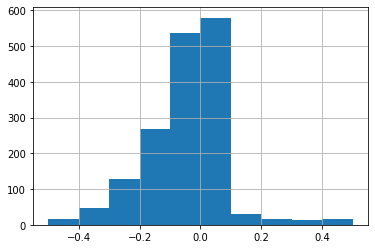

In [4]:
# steer 값 탐색
# 데이터셋의 분포가 좌회전으로 치우쳐 있는것을 알 수 있다.
# 테스트셋 -> 우회전으로 치우친 데이터 -> 어떻게 해결 ? -> data augmentation을 이용한 데이터 전처리
print(label_df['steer'].describe())

label_df['steer'].hist()

Index:  66
Image name:  330230.jpg
Steer:  -0.0862630129089284
Image shape:  (256, 512, 3)


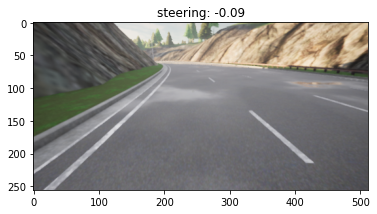

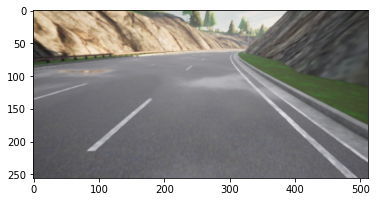

In [5]:
# X,Y 데이터 시각화 확인

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# 이미지를 좌우 반전시키는 함수 정의
def rotate_image(img_name):
    path = '/content/dataset/images/' + img_name
    img_data = Image.open(path).convert('RGB')

    # 좌우 반전
    flip_img = img_data.transpose(Image.FLIP_LEFT_RIGHT)

    return flip_img


def load_image(img_name):
    # https://m.blog.naver.com/nostresss12/221950215408

    path = '/content/dataset/images/' + img_name
    img_data = Image.open(path).convert('RGB')

    return img_data


def visualize_data(img_name, label):

    img = load_image(img_name)
    print("Image shape: ", np.array(img).shape)
    
    plt.imshow(img)
    plt.title("steering: {:.2f}".format(label))
    plt.show()

def visualize_rotate_data(img_name, label):

    img = rotate_image(img_name)
    print("Image shape: ", np.array(img).shape)
    
    plt.imshow(img)
    plt.title("steering: {:.2f}".format(label))
    plt.show()


i = np.random.choice(label_df.index)
img_name = label_df['img'][i]
label = label_df[label_df['img'] == img_name]['steer'].values[0]
print("Index: ", i)
print("Image name: ", img_name)
print("Steer: ", label)

# 이미지와 이미지의 크기 출럭
visualize_data(img_name, label)

# 앞의 이미지를 좌우 반전 시킨 결과
plt.imshow(rotate_image(img_name))

In [6]:
# Data Augmentation
# 좌우 반전을 통해 우회전에 대한 데이터셋을 추가시킴
# 이미지 반전 -> label 값에 부호만 반대로 해서 데이터에 추가
cnt = 0
idx = len(label_df) - 1
for i, j in zip(label_df['img'], label_df['steer']):
    img_name = i
    cnt += 1
    idx += 1
    path = '/content/dataset/images/' + str(cnt) +'.jpg'
    rotate_image(img_name).save(path)
    new_path = str(cnt) + '.jpg'
    label_df.loc[idx] = [new_path, -j]

count    3304.000000
mean        0.000000
std         0.139135
min        -0.500000
25%        -0.049233
50%         0.000000
75%         0.049233
max         0.500000
Name: steer, dtype: float64


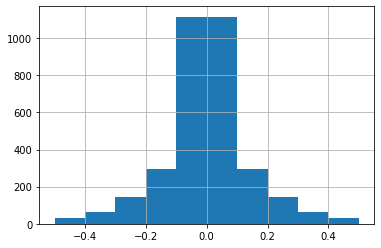

In [7]:
print(label_df['steer'].describe())

label_df['steer'].hist()

# 3. 딥러닝 모델 생성

In [8]:
# Functional과 Sequential로 구성 -> 차이점 설명
# 마지막에 ReLU vs Sigmoid
# 전이학습?
# Early Stopping

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def get_model():

    model = Sequential()

    model.add(Conv2D(24, (5, 5), activation='relu', input_shape=(256, 512, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(36, (5, 5), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(48, (5, 5), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='sigmoid'))
    model.add(Dense(1))

    # ▼▼▼▼ Nvidia의 End-to-End 모델 구현 ▼▼▼▼
    # input data shape: (None, 256, 512, 3)
    # output data shape: (None, 1)
    # ▲▲▲▲ Nvidia의 End-to-End 모델 구현 ▲▲▲▲

    return model

model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 508, 24)      1824      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 254, 24)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 250, 36)      21636     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 125, 36)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 57, 121, 48)       43248     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 60, 48)       0

# 4. 학습 및 검증 데이터 분할

In [10]:
# Set the number of training and validation data
# data augmentation으로 data의 개수가 늘어났기 때문에 비율 조정
VAL_RATIO = 0.1

len_val = int(np.ceil(len(label_df) * VAL_RATIO))
len_train = int(len(label_df) - len_val)

print(len(label_df), len_train, len_val)

def split_train_val(df, val_ratio):
    '''
    입력받은 데이터프레임를 ratio 기준으로 
    학습용 데이터프레임과 검증용 데이터프레임으로 분할
    입력 df: 데이터프레임
    입력 val_ratio: 검증데이터 비율
    출력 train_df: 학습용 데이터프레임
    출력 val_df: 검증용 데이터프레임
    '''
        
    # ▼▼▼▼ split_train_val 함수 구현을 위한 코드 작성 ▼▼▼▼

    shuffled_df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # loc vs iloc의 차이점
    # iloc : 해당 하는 위치의 인덱스
    # loc : 라벨 값 기반으로 데이터 추출
    df_train = shuffled_df.iloc[int(len(label_df)*val_ratio)+1:].reset_index(drop=True)
    df_val = shuffled_df.iloc[:int(len(label_df)*val_ratio)+1].reset_index(drop=True)

    # ▲▲▲▲ split_train_val 함수 구현을 위한 코드 작성 ▲▲▲▲

    return df_train, df_val

label_train, label_val = split_train_val(label_df, VAL_RATIO)
print(len(label_df), len(label_train), len(label_val))

3304 2973 331
3304 2973 331


In [11]:
# Duplication Check
for i in range(len(label_train)):
    for j in range(len(label_val)):
        if label_train.loc[i, 'img'] == label_val.loc[j, 'img']:
            print("{}th of train-set and {}th of validation-set are the same data.".format(i, j))
            print("Deduplication is needed")
            break

# 5. 데이터로더 생성

In [12]:
# dataloader를 쓰는 이유 -> memory 관리

In [13]:
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import math


# https://minimin2.tistory.com/100
class DataLoader(Sequence):
    def __init__(self, label_df, batch_size, shuffle=False):
        self.label_df = label_df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.x_max = 0.5
        self.x_min = -0.5

    def on_epoch_end(self):
        # dataframe의 길이만큼 index array를 만든다.
        self.indices = np.arange(len(self.label_df))
        if self.shuffle == True:
            np.random.shuffle(self.indices)
    
    def __len__(self):
        return math.ceil(len(self.label_df) / self.batch_size)
    
    def __getitem__(self, idx):
        
        # batch size만큼 index를 불러온다.
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        
        # image
        batch_x = [self.label_df.iloc[i, 0] for i in indices]
        # label(steering)
        batch_y = [self.label_df.iloc[i, 1] for i in indices]

        # image = np.array(Image.open(path))
        # batch_x = np.array(Image.open(path))

        batch_x = [np.array(load_image(img_name)) / 255. for img_name in batch_x]
        
        # ▼▼▼▼ batch_x 변수에 이미지 데이터 로드 ▼▼▼▼
        # np.array(batch_x).shape = (batch_size, 256, 512, 3)
        # ▲▲▲▲ batch_x 변수에 이미지 데이터 로드 ▲▲▲▲

        # ▼▼▼▼ batch_y Min-Max Normalization ▼▼▼▼

        # batch_y = self.min_max_normalize(batch_y)
        batch_y = [self.min_max_normalize(y) for y in batch_y]
        
        # ▲▲▲▲ batch_y Min-Max Normalization ▲▲▲▲
        
        return np.array(batch_x), np.array(batch_y)

    def min_max_normalize(self, x):

        x_scaled = (x - self.x_min) / (self.x_max - self.x_min)
        
        return x_scaled

In [14]:
total_data_loader = DataLoader(label_df=label_df, batch_size=4, shuffle=False)
x, y = total_data_loader[0]
# batch size
print(x.shape)
print(y.shape)
print(y)

(4, 256, 512, 3)
(4,)
[0.51936109 0.59079081 0.59079081 0.4927032 ]


In [15]:
# 학습 및 검증 데이터로더 생성

# batch_size : 16 -> 8로 조정
batch_size = 8 
train_data_loader = DataLoader(label_df=label_train, batch_size=batch_size, shuffle=True)

val_data_loader = DataLoader(label_df=label_val, batch_size=batch_size, shuffle=True)

# 6. 학습 설정

In [16]:
LOSS = 'mae'
OPTIMIZER = 'adam'
METRIC = 'mse'
model.compile(loss = LOSS,
              optimizer = OPTIMIZER,
              metrics = [METRIC])

In [17]:
# Early Stopping 추가, patience = 7
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=7)

In [18]:
# 단위변환 민감 -> MAE
# 차이를 극대화 -> MSE
# RMSE

In [19]:
epochs = 50

# 학습 종료 시점에 대한 고찰
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

history = model.fit(x = train_data_loader, validation_data = val_data_loader, epochs = epochs, callbacks=[early_stopping])

Epoch 1/50
372/372 [==============================] - 41s 83ms/step - loss: 0.0962 - mse: 0.0197 - val_loss: 0.0863 - val_mse: 0.0150
Epoch 2/50
372/372 [==============================] - 29s 77ms/step - loss: 0.0776 - mse: 0.0131 - val_loss: 0.0705 - val_mse: 0.0105
Epoch 3/50
372/372 [==============================] - 30s 80ms/step - loss: 0.0664 - mse: 0.0093 - val_loss: 0.0587 - val_mse: 0.0070
Epoch 4/50
372/372 [==============================] - 29s 79ms/step - loss: 0.0539 - mse: 0.0064 - val_loss: 0.0498 - val_mse: 0.0056
Epoch 5/50
372/372 [==============================] - 29s 78ms/step - loss: 0.0487 - mse: 0.0052 - val_loss: 0.0447 - val_mse: 0.0043
Epoch 6/50
372/372 [==============================] - 29s 78ms/step - loss: 0.0417 - mse: 0.0039 - val_loss: 0.0413 - val_mse: 0.0036
Epoch 7/50
372/372 [==============================] - 29s 78ms/step - loss: 0.0371 - mse: 0.0031 - val_loss: 0.0427 - val_mse: 0.0043
Epoch 8/50
372/372 [==============================] - 29s 78ms

# 8. 학습이 완료된 모델 저장

In [20]:
model.save('my_model')
!zip -r my_model.zip my_model/*

  adding: my_model/assets/ (stored 0%)
  adding: my_model/keras_metadata.pb (deflated 94%)
  adding: my_model/saved_model.pb (deflated 89%)
  adding: my_model/variables/ (stored 0%)
  adding: my_model/variables/variables.index (deflated 70%)
  adding: my_model/variables/variables.data-00000-of-00001 (deflated 39%)


# 9. 제출 전 저장된 모델이 정상적으로 로드되는지 확인!

In [21]:
from tensorflow.keras.models import load_model

!unzip my_model.zip -d check/

loaded_model = load_model('check/my_model')
print(loaded_model.summary())

loaded_model.evaluate(x = val_data_loader)

Archive:  my_model.zip
   creating: check/my_model/assets/
  inflating: check/my_model/keras_metadata.pb  
  inflating: check/my_model/saved_model.pb  
   creating: check/my_model/variables/
  inflating: check/my_model/variables/variables.index  
  inflating: check/my_model/variables/variables.data-00000-of-00001  
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 508, 24)      1824      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 254, 24)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 250, 36)      21636     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 125, 36)      0         
 2D

[0.02902103215456009, 0.001804384752176702]